In [2]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 6.6 MB/s eta 0:00:00


In [3]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import shap

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import time
from sklearn.inspection import permutation_importance

In [4]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("Using GPU:", torch.cuda.get_device_name(0))
else:
  device = torch.device("cpu")
  print("CUDA is not availible. Using CPU instead.")

Using GPU: Tesla T4


### Data Cleaning and Preprocessing
### Steps:
1. Drop any row with missing/unknown values. This reduces size of dataset from 106 M to 700 K.
2. Get rid of all columns related to date/time.
3. One-hot encode all categorical variables and keep only one of any column with binary outcome after one-hot encoding.

In [5]:
df = pd.read_pickle("/content/drive/MyDrive/Machine Learning Project/Code/cdcdata.pkl")

In [6]:
for col in df.columns:
    print(col)

cdc_case_earliest_dt
cdc_report_dt
current_status
sex
age_group
race_ethnicity_combined
hosp_yn
icu_yn
death_yn
medcond_yn
pos_spec_dt
onset_dt


In [7]:
def one_hot_encoding_features(df, columns_to_encode):
  for column in columns_to_encode:
    if column not in df.columns:
      raise ValueError(f"Column '{column}' not found in DataFrame.")
  df_encoded = pd.get_dummies(df, columns=columns_to_encode)

  return df_encoded

columns_to_encode = ['current_status', 'sex', 'age_group', 'race_ethnicity_combined', 'hosp_yn', 'icu_yn', 'death_yn', 'medcond_yn']
df_encoded = one_hot_encoding_features(df, columns_to_encode)

In [8]:
cols_to_drop = ['cdc_case_earliest_dt', 'cdc_report_dt', 'pos_spec_dt', 'onset_dt', 'hosp_yn_No', 'icu_yn_No', 'death_yn_No', 'medcond_yn_No']
df_dropped = df_encoded.drop(cols_to_drop, axis=1)
df = df_dropped

### Exploratory Data Analysis (EDA)

In [9]:
df.head()

,current_status_Laboratory-confirmed case,current_status_Probable Case,sex_Female,sex_Male,sex_Other,age_group_0 - 9 Years,age_group_10 - 19 Years,age_group_20 - 29 Years,age_group_30 - 39 Years,age_group_40 - 49 Years,...,"race_ethnicity_combined_Asian, Non-Hispanic","race_ethnicity_combined_Black, Non-Hispanic",race_ethnicity_combined_Hispanic/Latino,"race_ethnicity_combined_Multiple/Other, Non-Hispanic","race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic","race_ethnicity_combined_White, Non-Hispanic",hosp_yn_Yes,icu_yn_Yes,death_yn_Yes,medcond_yn_Yes
6,True,False,False,True,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
11,True,False,False,True,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,True
30,True,False,False,True,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,True
36,True,False,False,True,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,True
40,True,False,False,True,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,True


### Features

In [10]:
for col in df.columns:
    print(col)

current_status_Laboratory-confirmed case
current_status_Probable Case
sex_Female
sex_Male
sex_Other
age_group_0 - 9 Years
age_group_10 - 19 Years
age_group_20 - 29 Years
age_group_30 - 39 Years
age_group_40 - 49 Years
age_group_50 - 59 Years
age_group_60 - 69 Years
age_group_70 - 79 Years
age_group_80+ Years
race_ethnicity_combined_American Indian/Alaska Native, Non-Hispanic
race_ethnicity_combined_Asian, Non-Hispanic
race_ethnicity_combined_Black, Non-Hispanic
race_ethnicity_combined_Hispanic/Latino
race_ethnicity_combined_Multiple/Other, Non-Hispanic
race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic
race_ethnicity_combined_White, Non-Hispanic
hosp_yn_Yes
icu_yn_Yes
death_yn_Yes
medcond_yn_Yes


### Check target class label distribution (death status)

We see we have a large data imbalance between non-death and death cases, with 96% being non-death and the remaining death cases. This may impact our modeling.

death_yn_Yes
False    701401
True      28786
Name: count, dtype: int64
death_yn_Yes
False    0.960577
True     0.039423
Name: count, dtype: float64


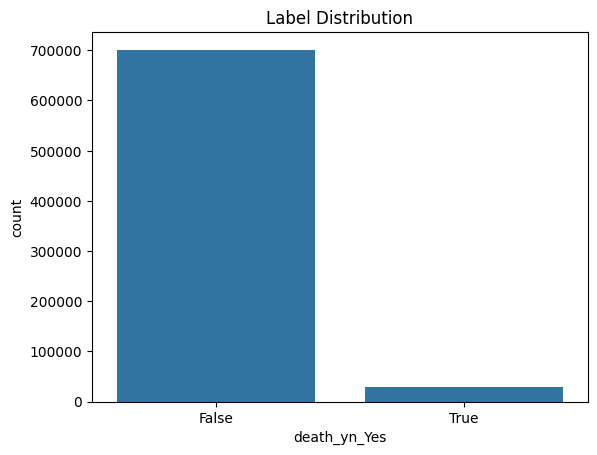

In [11]:
label_counts = df['death_yn_Yes'].value_counts()
print(label_counts)

label_proportions = label_counts / len(df)
print(label_proportions)

sns.countplot(x=df['death_yn_Yes'])
plt.title('Label Distribution')
plt.show()

### Make sure we have no null values

In [12]:
#Proportion of each feature that is null.
df.isnull().sum()

current_status_Laboratory-confirmed case                                        0
current_status_Probable Case                                                    0
sex_Female                                                                      0
sex_Male                                                                        0
sex_Other                                                                       0
age_group_0 - 9 Years                                                           0
age_group_10 - 19 Years                                                         0
age_group_20 - 29 Years                                                         0
age_group_30 - 39 Years                                                         0
age_group_40 - 49 Years                                                         0
age_group_50 - 59 Years                                                         0
age_group_60 - 69 Years                                                         0
age_group_70 - 7

In [13]:
df.shape

(730187, 25)

### Train/Test/Validation Split

Set death status at the target value and the rest as features. Prepare 8:1:1 train, test, validation split.

In [14]:
features = df.drop('death_yn_Yes', axis = 1)
labels = df['death_yn_Yes']
features_tensor = torch.tensor(features.values, dtype=torch.float32)
labels_tensor = torch.tensor(labels.values, dtype=torch.float32)

In [15]:
X = features_tensor.numpy()
y = labels_tensor.numpy()

X_temp, X_test, y_temp, y_test = train_test_split(X,y,test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=1/9, random_state=42)

### 2. Random Forest Model

In [16]:
#Initialize RF model
rf_classifier = RandomForestClassifier(n_estimators=100, criterion = 'entropy', random_state=42)

#Fit the model on training data
rf_classifier.fit(X_train, y_train)

#Predict on validation data
y_pred_val = rf_classifier.predict(X_val)

#Predict on testing data
y_pred_test = rf_classifier.predict(X_test)

### Model Evaluation

During the validation for our RF classifier model, we achieved an accuracy of 96.68% and an AUC of 0.96, indicating that it correctly predicts death status in the majority of cases. The precision for non-death is 0.98, which is quite high, indicating that our model correctly predicts that a patient will not die 98% of the time. The recall is 0.99, suggesting that our model is very good at identifying all the true cases of non-death.
The F1-score is 0.98, indicating an overall strong performance.  However, the precision for predicting death is 0.59, meaning that our model correctly predicts death only about 59% of the time. The recall is 0.43, indicating that our model only correctly identifies 43% of the actual death cases, which is not ideal. The F1-score is 0.50, which shows that our model is less effective at predicting death compared to predicting survival. The PR-AUC is 0.52.

During our testing for our RF classifier model, we achieved an accuracy of 96.78% and an AUC of 0.96, very similar to validation. The precision and recall for non-death are 0.96 and 0.97, respectively. The F1-score remains high at 0.97. But for predicting death, the precision has dropped significantly to 0.04, indicating many false positives for the death prediction. The recall is also very low for predicting death, at 0.03, suggesting the model is missing many of the actual death cases. The F1-score is 0.04, suggesting very weak performance and that once again our model is less effective at predicting death compared to predicting survival. The PR-AUC is 0.53.

These results must be due to the data imbalance we have regarding death status.

In [17]:
#Evaluate the model
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))
print(classification_report(y_val, y_pred_val))

print("Testing Accuracy:", accuracy_score(y_test, y_pred_test))
print(classification_report(y_val, y_pred_test))

Validation Accuracy: 0.9668031608211561
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98     70220
         1.0       0.59      0.43      0.50      2799

    accuracy                           0.97     73019
   macro avg       0.79      0.71      0.74     73019
weighted avg       0.96      0.97      0.96     73019

Testing Accuracy: 0.967843985811912
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97     70220
         1.0       0.04      0.03      0.04      2799

    accuracy                           0.94     73019
   macro avg       0.50      0.50      0.50     73019
weighted avg       0.93      0.94      0.93     73019



In [18]:
#Predict probabilities for the test and val set
y_scores_val = rf_classifier.predict_proba(X_val)[:, 1]
y_scores_test = rf_classifier.predict_proba(X_test)[:, 1]

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, ConfusionMatrixDisplay

#Function to plot ROC Curve
def plot_roc_curve(y_true, y_score, title):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

#Function to plot Precision-Recall Curve
def plot_precision_recall_curve(y_true, y_score, title):
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    average_precision = average_precision_score(y_true, y_score)

    plt.figure()
    plt.step(recall, precision, where='post', label='Precision-Recall curve (area = %0.2f)' % average_precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(title)
    plt.legend(loc="lower left")
    plt.show()

#Function to plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

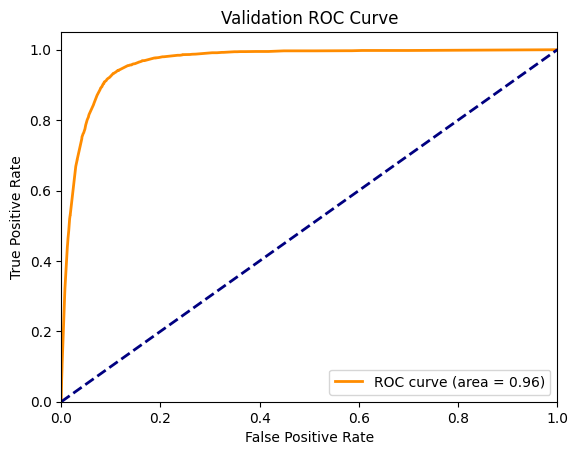

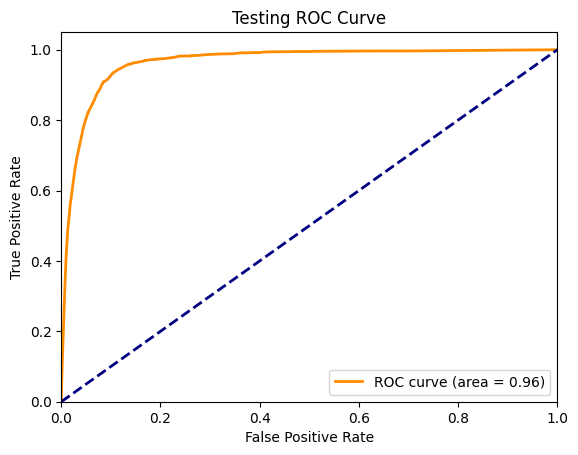

In [20]:
#Plot ROC Curve for validation set
plot_roc_curve(y_val, y_scores_val, "Validation ROC Curve")

#Plot ROC Curve for test set
plot_roc_curve(y_test, y_scores_test, "Testing ROC Curve")

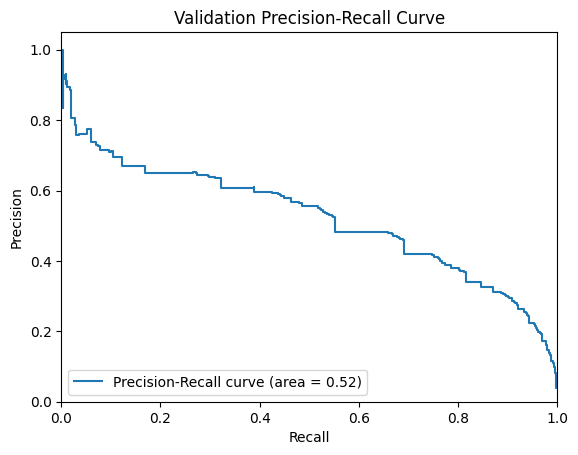

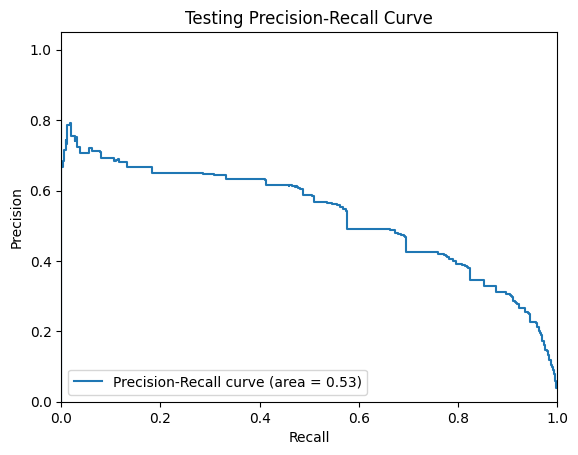

In [21]:
#Plot Precision-Recall Curve for validation set
plot_precision_recall_curve(y_val, y_scores_val, "Validation Precision-Recall Curve")

#Plot Precision-Recall Curve for test set
plot_precision_recall_curve(y_test, y_scores_test, "Testing Precision-Recall Curve")

Validation


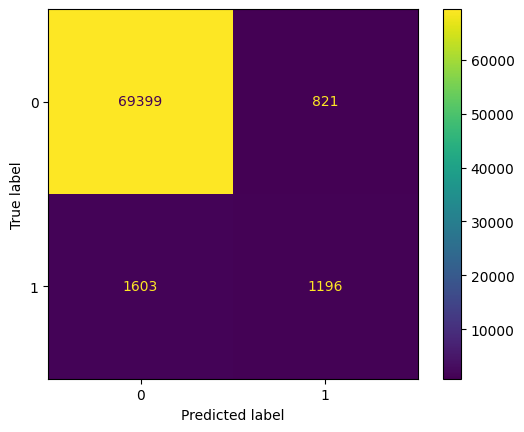

Testing


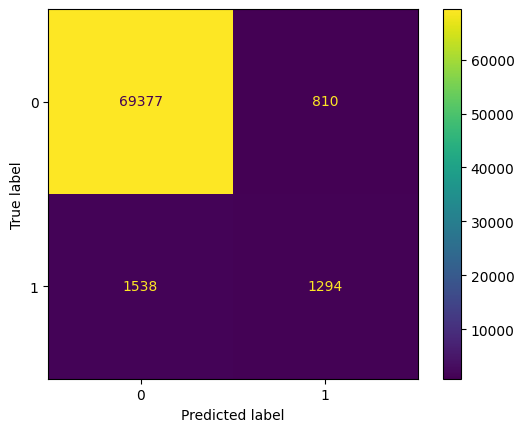

In [22]:
#Plot Confusion Matrix for validation set
print("Validation")
plot_confusion_matrix(y_val, y_pred_val)

#Plot Confusion Matrix for test set
print("Testing")
plot_confusion_matrix(y_test, y_pred_test)

In [23]:
pip install shap

### Feature Importance Analysis

We want to see what features are important and drive predicting mortality in our RF model.

We see that hospitalization status, ICU admission status, and pre-existing medical condtions are the driving features.

In [24]:
feature_names = ['current_status_Laboratory-confirmed case', 'current_status_Probable Case','sex_Female',
                 'sex_Male', 'sex_Other', 'age_group_0 - 9 Years', 'age_group_10 - 19 Years', 'age_group_20 - 29 Years',
                 'age_group_30 - 39 Years', 'age_group_40 - 49 Years', 'age_group_50 - 59 Years', 'age_group_60 - 69 Years',
                 'age_group_70 - 79 Years', 'age_group_80+ Years', 'race_ethnicity_combined_American Indian/Alaska Native, Non-Hispanic',
                 'race_ethnicity_combined_Asian, Non-Hispanic', 'race_ethnicity_combined_Black, Non-Hispanic', 'race_ethnicity_combined_Hispanic/Latino',
                 'race_ethnicity_combined_Multiple/Other, Non-Hispanic', 'race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic',
                 'race_ethnicity_combined_White, Non-Hispanic', 'hosp_yn_Yes', 'icu_yn_Yes', 'medcond_yn_Yes']

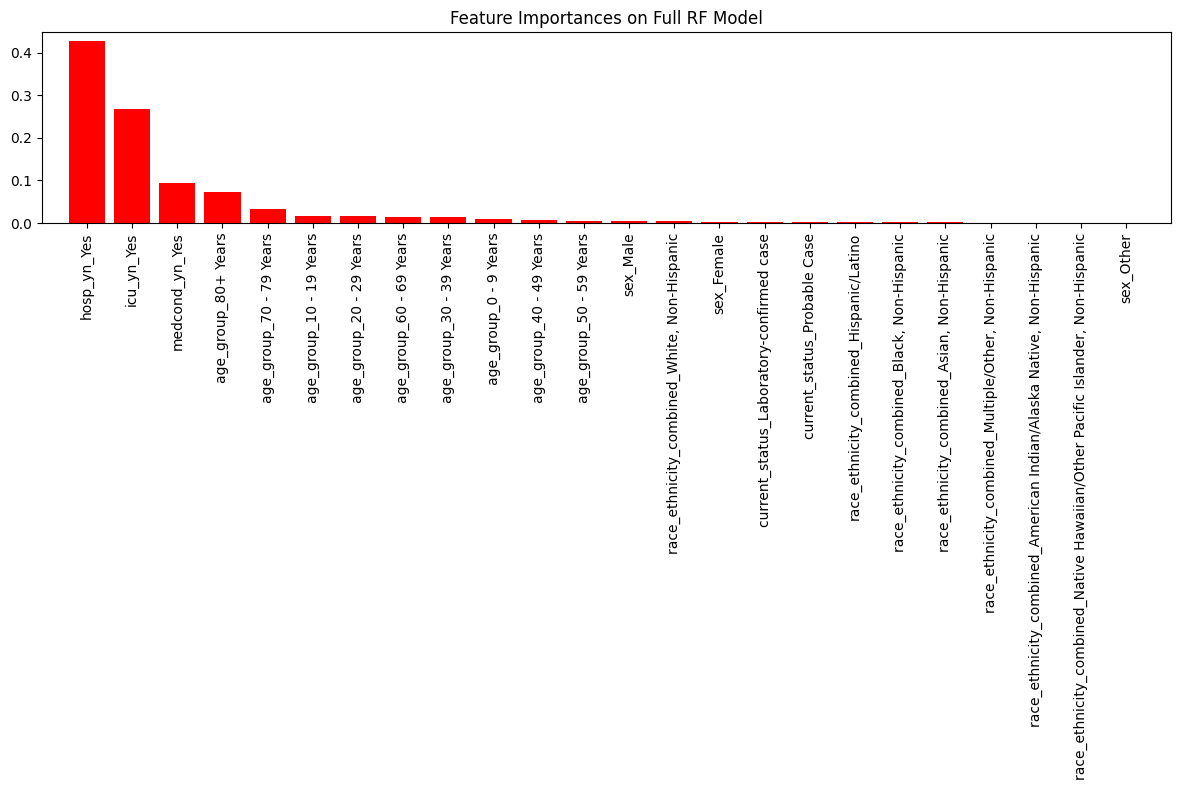

In [25]:
import shap

#Feature Importance Plot
importances = rf_classifier.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature Importances on Full RF Model")
plt.bar(range(len(importances)), importances[indices], color="r", align="center")
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, len(importances)])
plt.tight_layout()
plt.show()

However, using 'feature_importances_' with the way it's calculated, it can be misleading for features that have unique values. Therefore, there is the permutation method, where features are shuffled n times and the model is refitted to estimate the importance of it, thereby reducing bias.

We see that hospitalization status, ICU admission status, and pre-existing medical condtions are still the driving features for our model.

In [26]:
import time
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    rf_classifier, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 165.939 seconds


<ipython-input-27-f5d927e8002c>:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


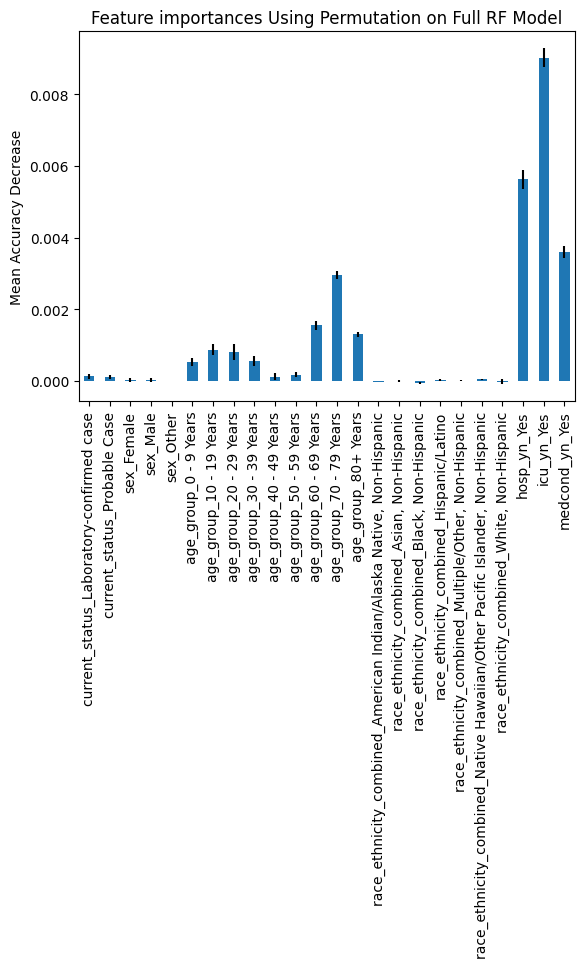

In [27]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances Using Permutation on Full RF Model")
ax.set_ylabel("Mean Accuracy Decrease")
fig.tight_layout()
plt.show()

Previous research papers used SHAP values when performing feature analysis. We will do the same.

In [28]:
explainer = shap.TreeExplainer(rf_classifier)
#Too large
#shap_values = explainer.shap_values(X_train)

X_sample = shap.sample(X_train, 100)
shap_values_sample = explainer.shap_values(X_sample)

#Check shapes
print(f"SHAP values shape: {np.array(shap_values_sample).shape}")
print(f"X_train shape: {X_train.shape}")

shap_values_positive_class = shap_values_sample[:, :, 1]

SHAP values shape: (100, 24, 2)
X_train shape: (584149, 24)


 The calculation of SHAP values is done by comparing the prediction of the model with and without the feature in every possible way of adding the feature to the model.The color of the dot represents the value of the feature and the X-axis depicts the direction and magnitude of the impact. Red colored dots represent high value of the feature and the blue represents lower value. A positive SHAP value means the feature value increases likelihood of COVID-19 mortality. For features with positive SHAP value for red dots, suggests directly proportional variable to outcome of interest and those with positive SHAP value for blue dots, suggest inverse correlation.

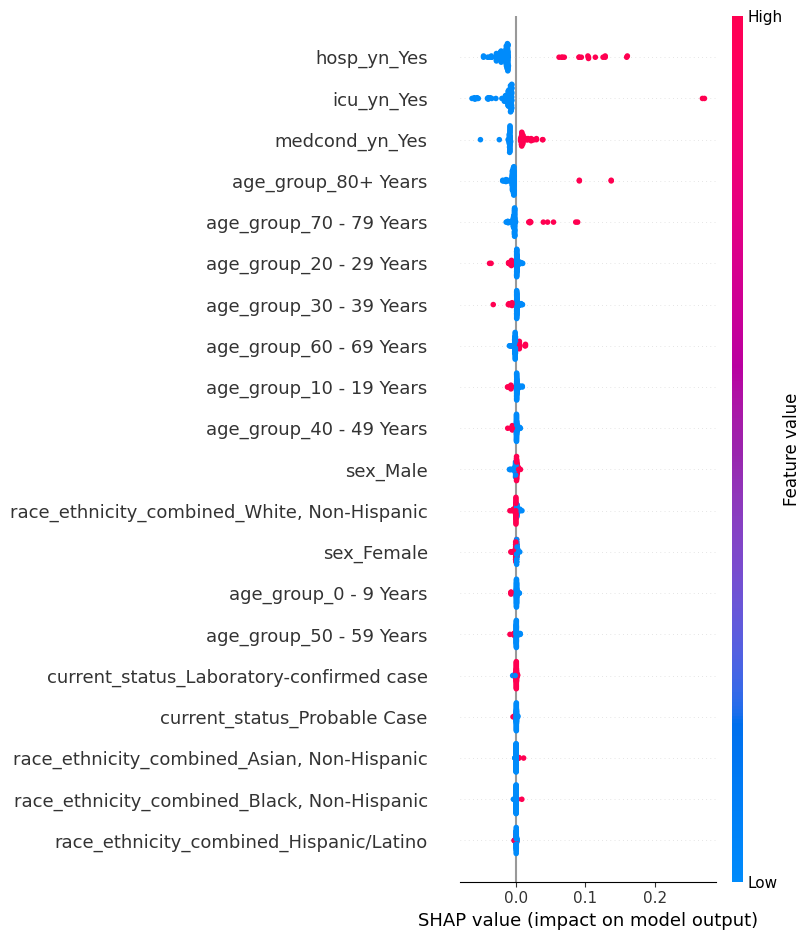

In [29]:
shap.summary_plot(shap_values_positive_class, X_sample, feature_names=feature_names, plot_type="dot")